<a href="https://colab.research.google.com/github/DiegoLeonG96/Tarea2_MLA/blob/main/Tarea_2_MLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Profesor: Tomás Fontecilla </em><br>
    <em>Curso: Machine Learning Avanzado </em><br>

</div>


# Tarea 2: Red Neuronal Convolucional
**Integrantes**:
- Kurt Castro
- Diego León
- Cristian Pizarro

## 1. Introducción

## 2. Objetivo

## 3. Metodología

## 4.  Carga y Preprocesamiento de Datos

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import models, layers, optimizers, regularizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
import kagglehub
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score
# Establecer la semilla para Python
random.seed(42)

# Establecer la semilla para NumPy
np.random.seed(42)

# Establecer la semilla para TensorFlow
tf.random.set_seed(42)

Activar GPU en "Entorno de Ejecución". No lo olviden o estarán horas entrenando!

In [2]:
# Verifica las GPUs disponibles
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Se encontró GPU: {gpus}")
else:
    print("No se encontró GPU. Asegúrate de haber activado el entorno con GPU en Colab.")

Se encontró GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Download latest version
path = kagglehub.dataset_download("samuelcortinhas/muffin-vs-chihuahua-image-classification")

print("Path to dataset files:", path)

100%|██████████| 474M/474M [00:06<00:00, 72.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/versions/2


In [4]:
base_path = "/root/.cache/kagglehub/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification/versions/2"

In [5]:
#image generator
data_generator = ImageDataGenerator(rescale=1./255,
                                    vertical_flip=True,
                                    horizontal_flip=True)

# train y test
train_dir = f'{base_path}/train'
test_dir = f'{base_path}/test'

batch_size = 16
num_classes = 2


# generators
image_size = (150, 150)
input_shape = (150, 150, 3)

# Cargar datos directamente
X_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

X_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    image_size=image_size,
    batch_size=batch_size
)

# Convertir a tensores numpy si es necesario
X_train, y_train = [], []
for images, labels in X_train_ds:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_test, y_test = [], []
for images, labels in X_test_ds:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

# Combinar los datos en arreglos numpy
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train).ravel()
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test).ravel()

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
X_train shape: (4733, 150, 150, 3), y_train shape: (4733,)
X_test shape: (1184, 150, 150, 3), y_test shape: (1184,)


## 5. Aplicación de Modelos

## MLP (Multilayer Perceptron)

In [6]:
# Dimensiones originales de las imágenes
num_samples, height, width, channels = X_train.shape

# Aplanamos las imágenes
X_train_flattened = X_train.reshape(num_samples, height * width * channels)

# Aplanamos el conjunto de pruebas
X_test_flattened = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

Epoch 1/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5742 - loss: 15535.5801 - val_accuracy: 0.7049 - val_loss: 166.0029
Epoch 2/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6254 - loss: 82.6192 - val_accuracy: 0.5343 - val_loss: 0.7490
Epoch 3/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5325 - loss: 0.7897 - val_accuracy: 0.5327 - val_loss: 0.7269
Epoch 4/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5374 - loss: 0.7203 - val_accuracy: 0.5317 - val_loss: 0.7318
Epoch 5/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5429 - loss: 0.6880 - val_accuracy: 0.5333 - val_loss: 0.7208
Epoch 6/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5472 - loss: 0.6728 - val_accuracy: 0.5343 - val_loss: 0.6816
Epoch 7/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5897 - loss: 0.6468 - val_accuracy: 0.6695 - val_loss: 0.6569
Epoch 8/100
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5654 - loss: 0.6976 - 

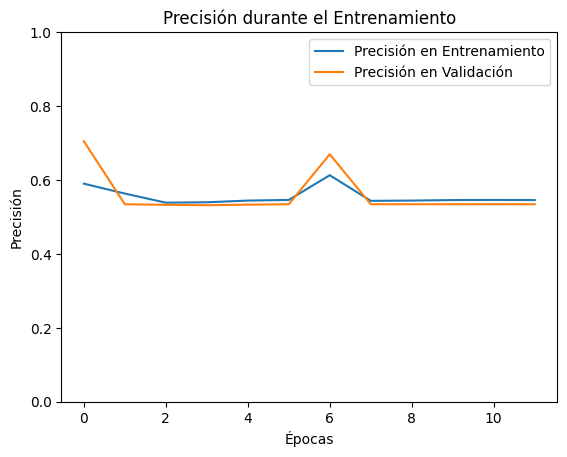

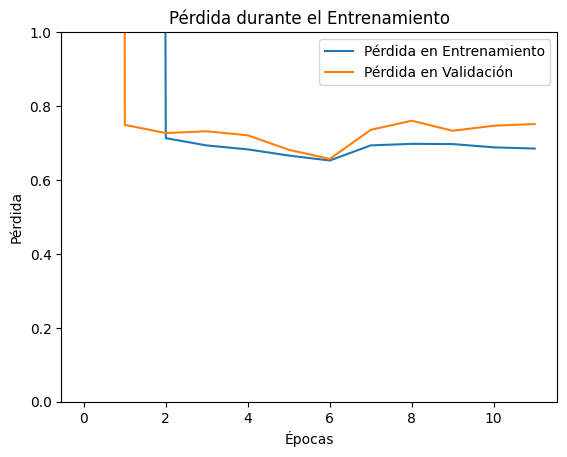

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC del modelo: 0.6904


In [8]:
hidden_units = 128
model_mlp = Sequential([
    Dense(hidden_units, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_mlp.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_mlp.fit(X_train_flattened, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    validation_split=0.4,
                    callbacks=[early_stopping])

# Evaluamos el modelo
train_acc=model_mlp.evaluate(X_train_flattened, y_train, batch_size=batch_size)[1]
test_acc=model_mlp.evaluate(X_test_flattened, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_mlp.predict(X_test_flattened)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

## CNN (Red Neuronal Convolucional)

In [9]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-2),
             metrics=['accuracy'])

In [11]:
X_train.shape

(4733, 150, 150, 3)

In [12]:
y_train.shape

(4733,)

Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9133 - loss: 0.2265 - val_accuracy: 0.8564 - val_loss: 0.3810
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9308 - loss: 0.1884 - val_accuracy: 0.8775 - val_loss: 0.3821
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9283 - loss: 0.1765 - val_accuracy: 0.7441 - val_loss: 0.8117
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9522 - loss: 0.1309 - val_accuracy: 0.8801 - val_loss: 0.3760
Epoch 5/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9613 - loss: 0.1158 - val_accuracy: 0.7897 - val_loss: 0.6797
Epoch 6/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9453 - loss: 0.1307 - val_accuracy: 0.7644 - val_loss: 0.9822
Epoch 7/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9646 - loss: 0.0973 - val_accuracy: 0.8522 - val_loss: 0.4953
Epoch 8/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8997 - loss: 0.2445 - 

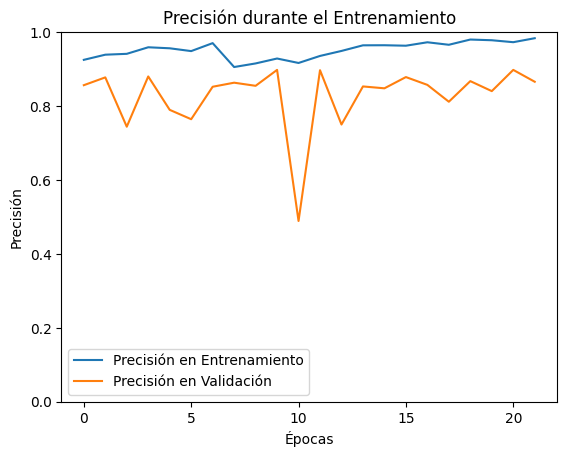

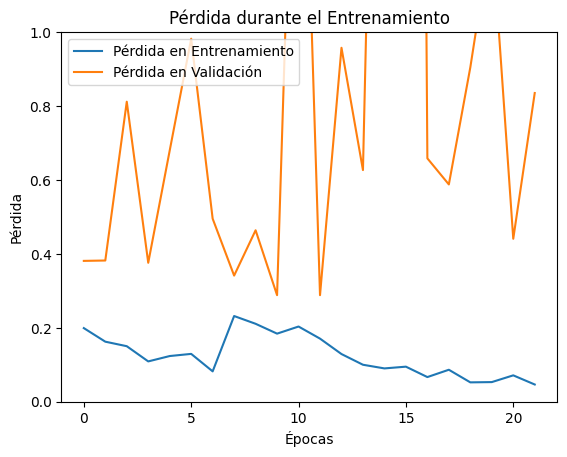

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC del modelo: 0.9626


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

#evalute the accuracy
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

## CNN 2 (Red Neuronal Convolucional)
(PROPUESTA): Mismo modelo anterior pero con Dropout.

In [15]:
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model_cnn.compile(loss='binary_crossentropy',
             optimizer = Adam(learning_rate=1e-2),
             metrics=['accuracy'])

Epoch 1/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7282 - loss: 0.6122 - val_accuracy: 0.6030 - val_loss: 1.2780
Epoch 2/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8352 - loss: 0.4151 - val_accuracy: 0.5836 - val_loss: 1.4376
Epoch 3/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8683 - loss: 0.3371 - val_accuracy: 0.5625 - val_loss: 1.9336
Epoch 4/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8688 - loss: 0.3242 - val_accuracy: 0.8100 - val_loss: 0.5200
Epoch 5/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.8762 - loss: 0.3122 - val_accuracy: 0.8454 - val_loss: 0.3823
Epoch 6/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8980 - loss: 0.2680 - val_accuracy: 0.7703 - val_loss: 0.6246
Epoch 7/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.8942 - loss: 0.2605 - val_accuracy: 0.8834 - val_loss: 0.2859
Epoch 8/100
296/296 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9080 - loss: 0.23

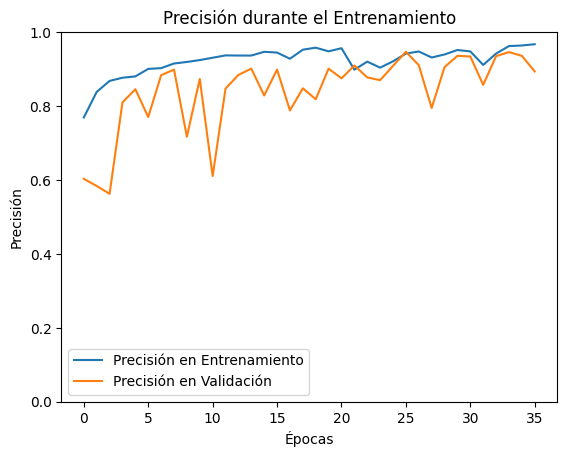

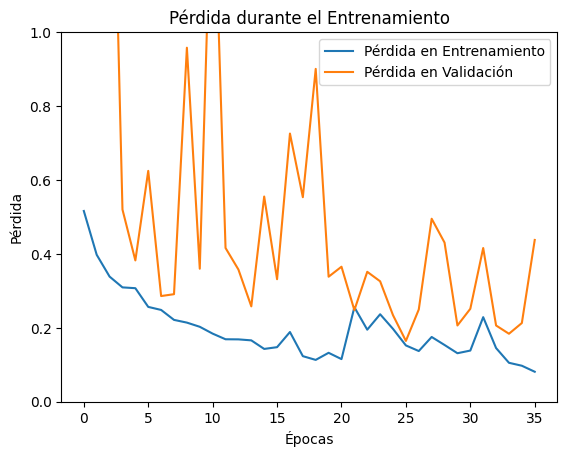

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
AUC del modelo: 0.9824


In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model_cnn.fit(
X_train, y_train,
batch_size=batch_size,
epochs=100,
verbose = 1,
validation_data=(X_test, y_test),
callbacks=[early_stopping]
)

#evalute the accuracy
train_acc=model_cnn.evaluate(X_train, y_train, batch_size=batch_size)[1]
test_acc=model_cnn.evaluate(X_test, y_test, batch_size=batch_size)[1]
print(f'Training accuracy: {train_acc:.2f}')
print(f'Test accuracy: {test_acc:.2f}')

# Graficamos la precisión
plt.plot(history.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

## CNN 2 (Segundo Modelo Red Neuronal Convolucional)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.8168 - loss: 0.4514 - val_accuracy: 0.7796 - val_loss: 0.4691
Epoch 2/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9018 - loss: 0.2414 - val_accuracy: 0.8564 - val_loss: 0.3336
Epoch 3/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9531 - loss: 0.1411 - val_accuracy: 0.8353 - val_loss: 0.4202
Epoch 4/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9706 - loss: 0.0911 - val_accuracy: 0.8868 - val_loss: 0.3057
Epoch 5/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9715 - loss: 0.0753 - val_accuracy: 0.8733 - val_loss: 0.3815
Epoch 6/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9833 - loss: 0.0505 - val_accuracy: 0.8311 - val_loss: 0.5130
Epoch 7/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9921 - loss: 0.0264 - val_accuracy: 0.8682 - val_loss: 0.3683
Epoch 8/100
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9972 - loss: 0.0175 -

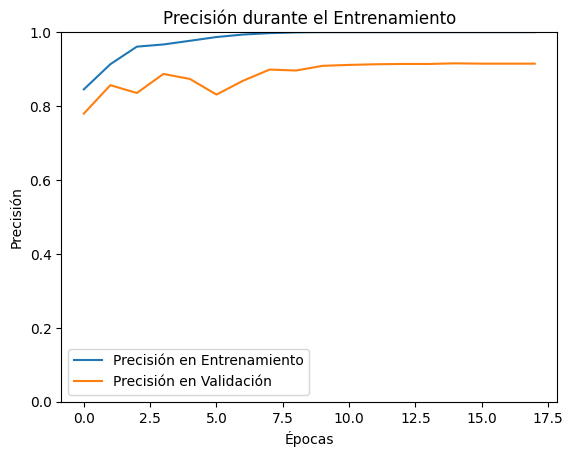

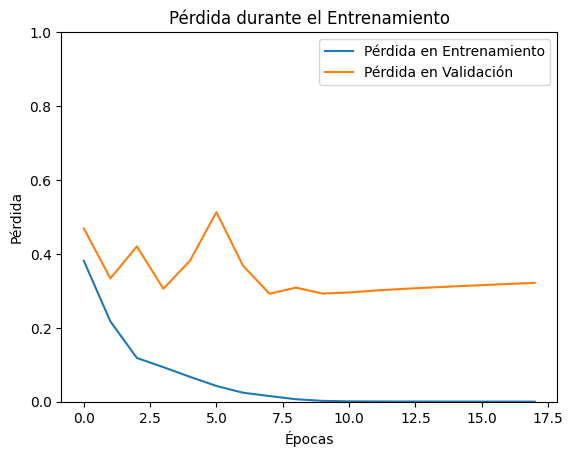

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
AUC del modelo: 0.9622


In [19]:
# Red Neuronal Convolucional (CNN) con diferentes parámetros

model_cnn2 = Sequential([
    # Capa Convolucional 1: 16 filtros de 3x3, función de activación ReLU
    Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'),  # padding='same' mantiene el tamaño de la imagen
    # Normalización por lotes para estabilizar y acelerar el entrenamiento
    BatchNormalization(),
    # Capa de Max Pooling 1: Reduce la dimensionalidad espacial
    MaxPooling2D((2, 2)),

    # Capa Convolucional 2: 32 filtros de 3x3, función de activación ReLU
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    # Normalización por lotes
    BatchNormalization(),
    # Capa de Max Pooling 2
    MaxPooling2D((2, 2)),

    # Capa Convolucional 3: 64 filtros de 3x3, función de activación ReLU
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    # Normalización por lotes
    BatchNormalization(),
    # Capa de Max Pooling 3
    MaxPooling2D((2, 2)),

    # Aplanar la salida para la capa densa
    Flatten(),

    # Capa Densa 1: 64 unidades, función de activación ReLU
    Dense(64, activation='relu'),
    # Regularización Dropout para prevenir el sobreajuste (opcional, pero recomendado)
    # layers.Dropout(0.5), # Ejemplo de dropout al 50%
    # Normalización por lotes
    BatchNormalization(),

    # Capa de Salida: 1 unidad (clasificación binaria), función de activación sigmoide
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model_cnn2.compile(loss='binary_crossentropy',  # Usamos binary_crossentropy para clasificación binaria
                  optimizer=Adam(learning_rate=1e-3), # Usamos Adam con una tasa de aprendizaje diferente al modelo anterior
                  metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history2 = model_cnn2.fit(X_train, y_train,
                         epochs=100,  # Aumentamos el número de épocas
                         batch_size=32, # Tamaño del lote 32
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping]
)

# Evaluar el modelo
train_acc2 = model_cnn2.evaluate(X_train, y_train, batch_size=32)[1]
test_acc2 = model_cnn2.evaluate(X_test, y_test, batch_size=32)[1]
print(f'Training accuracy (model_cnn2): {train_acc2:.2f}')
print(f'Test accuracy (model_cnn2): {test_acc2:.2f}')

# Graficamos la precisión
plt.plot(history2.history['accuracy'], label='Precisión en Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Precisión en Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.ylim(0, 1)
plt.legend()
plt.title('Precisión durante el Entrenamiento')
plt.show()

# Graficamos la pérdida
plt.plot(history2.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida en Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.ylim(0, 1)
plt.legend()
plt.title('Pérdida durante el Entrenamiento')
plt.show()

# Evaluamos el modelo con AUC
y_pred_prob = model_cnn2.predict(X_test)
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC del modelo: {auc:.4f}")

## 6. Comparación de Modelos

A continuación, presentaremos los resultados de los 3 modelos aplicados en el laboratorio:



*   MPL
*   CNN
*   CNN 2






### Métricas por modelo

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Resultados para MLP:
Matriz de Confusión:
[[639   1]
 [544   0]]


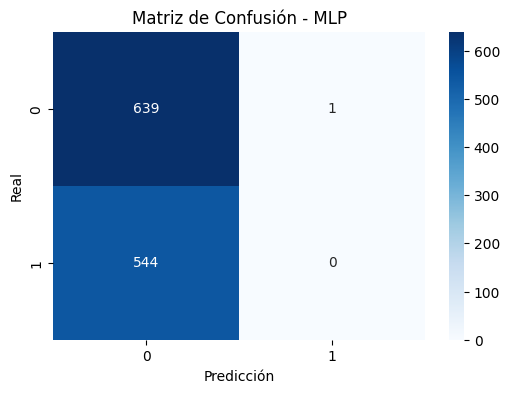

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       640
         1.0       0.00      0.00      0.00       544

    accuracy                           0.54      1184
   macro avg       0.27      0.50      0.35      1184
weighted avg       0.29      0.54      0.38      1184

Resultados para CNN:
Matriz de Confusión:
[[510 130]
 [ 93 451]]


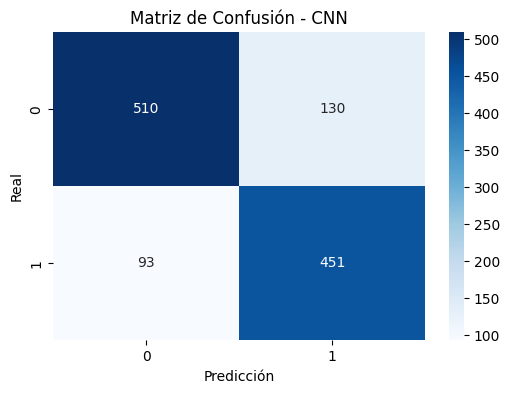

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.80      0.82       640
         1.0       0.78      0.83      0.80       544

    accuracy                           0.81      1184
   macro avg       0.81      0.81      0.81      1184
weighted avg       0.81      0.81      0.81      1184

Resultados para CNN2:
Matriz de Confusión:
[[606  34]
 [ 49 495]]


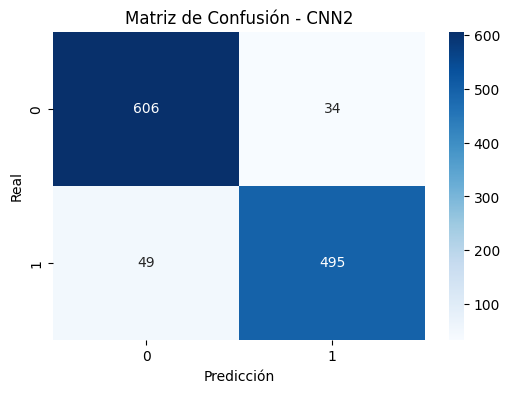

Informe de Clasificación:
              precision    recall  f1-score   support

         0.0       0.93      0.95      0.94       640
         1.0       0.94      0.91      0.92       544

    accuracy                           0.93      1184
   macro avg       0.93      0.93      0.93      1184
weighted avg       0.93      0.93      0.93      1184



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones para cada modelo
y_pred_mlp = (model_mlp.predict(X_test_flattened) > 0.5).astype("int32")
y_pred_cnn = (model_cnn.predict(X_test) > 0.5).astype("int32")
y_pred_cnn2 = (model_cnn2.predict(X_test) > 0.5).astype("int32")


# Función para mostrar la matriz de confusión y el informe de clasificación
def show_results(model_name, y_true, y_pred):
    print(f"Resultados para {model_name}:")
    cm = confusion_matrix(y_true, y_pred)
    print("Matriz de Confusión:")
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

    cr = classification_report(y_true, y_pred)
    print("Informe de Clasificación:")
    print(cr)


# Mostrar resultados para cada modelo
show_results("MLP", y_test, y_pred_mlp)
show_results("CNN", y_test, y_pred_cnn)
show_results("CNN2", y_test, y_pred_cnn2)

### Imágenes clasificadas erróneamente

In [ ]:
def plot_images_in_grid(images, titles, n_examples=10, n_rows=2, figsize=(15, 5)):
    """
    Generaliza la creación de una grilla para mostrar imágenes.

    Parameters:
    - images: Lista de imágenes a mostrar.
    - titles: Lista de títulos para cada imagen.
    - n_examples: Número máximo de ejemplos a mostrar.
    - n_rows: Número de filas en la grilla.
    - figsize: Tamaño de la figura (tupla).
    """
    n_cols = (n_examples + n_rows - 1) // n_rows  # Calcula el número de columnas
    fig, ax = plt.subplots(n_rows, n_cols, figsize=figsize)

    # Asegura que 'ax' sea una matriz bidimensional
    ax = ax.flatten() if n_rows > 1 else [ax]

    for idx in range(len(ax)):
        if idx < n_examples and idx < len(images):
            ax[idx].imshow(images[idx])
            ax[idx].set_title(titles[idx])
            ax[idx].axis('off')
        else:
            ax[idx].axis('off')  # Desactiva las subtramas no usadas

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.show()

Ejemplos de clasificaciones erróneas en el mejor modelo (segundo modelo convolucional)

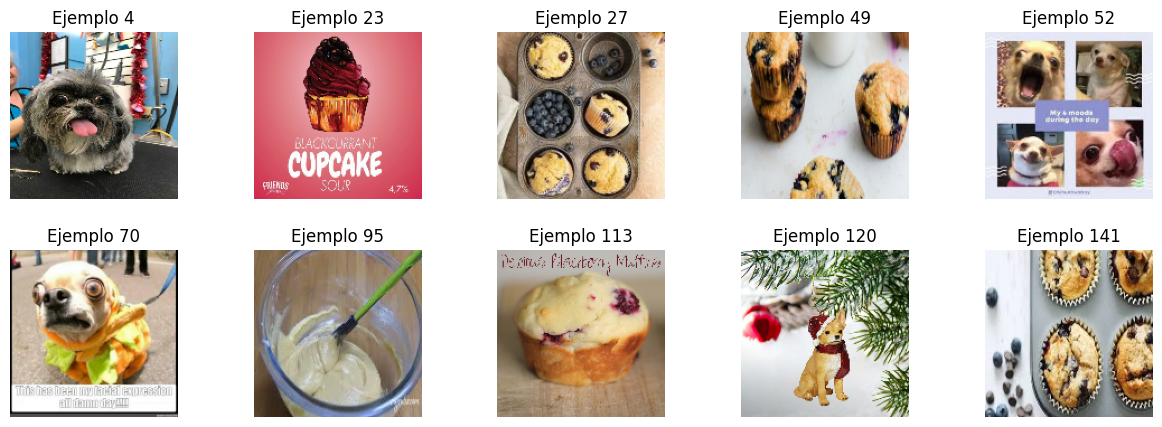

In [ ]:
# Ejemplo de uso con datos de prueba:
n_examples = 10
n_rows = 2

# Filtrar las imágenes y títulos a mostrar
filtered_images = [X_test[i] / 255 for i in range(len(y_test)) if y_pred_cnn2[i] != y_test[i]]
filtered_titles = [f'Ejemplo {i}' for i in range(len(y_test)) if y_pred_cnn2[i] != y_test[i]]

# Limitar al número de ejemplos deseados
filtered_images = filtered_images[:n_examples]
filtered_titles = filtered_titles[:n_examples]

# Llamar a la función para graficar
plot_images_in_grid(filtered_images, filtered_titles, n_examples=n_examples, n_rows=n_rows)


Se puede ver la gran dificultad para la clasificación en las imágenes mostrados para el modelo con mejor desempeño. Ejemplos como el 27, 49 y el 141 son muffins agrupados juntos que se ven muy similares a chihuahuas agrupados como en el ejemplo 52. Otros casos como el ejemplo 4 es muy difícil de clasificar, puesto que esa raza de perro tiene expresiones similares a un chihuahua y no lo es

Ejemplos de clasificaciones erróneas en el primer modelo convolucional pero correctas en el segundo

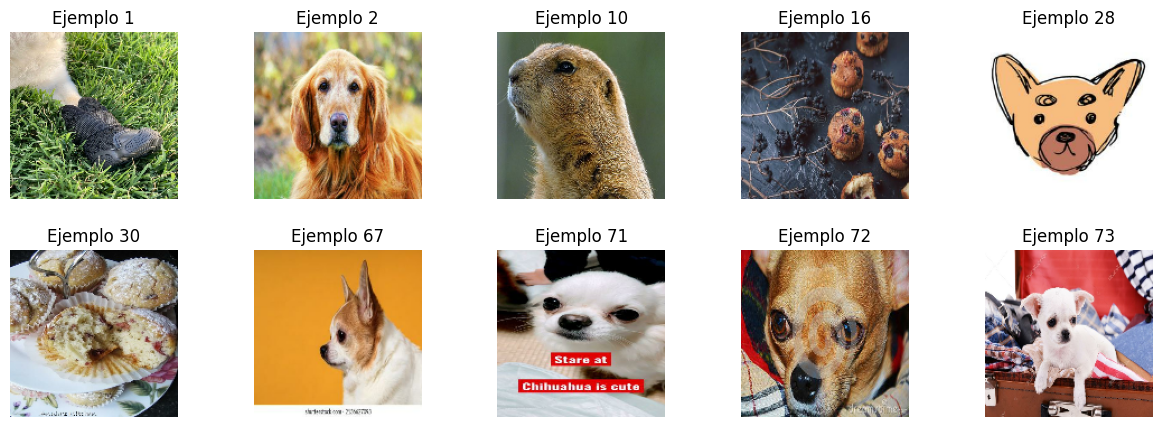

In [ ]:
# Ejemplo de uso con datos de prueba:
n_examples = 10
n_rows = 2

# Filtrar las imágenes y títulos a mostrar
filtered_images = [X_test[i] / 255 for i in range(len(y_test)) \
                   if y_pred_cnn2[i] == y_test[i] and y_pred_cnn[i] != y_test[i]]
filtered_titles = [f'Ejemplo {i}' for i in range(len(y_test)) \
                   if y_pred_cnn2[i] == y_test[i] and y_pred_cnn[i] != y_test[i]]

# Limitar al número de ejemplos deseados
filtered_images = filtered_images[:n_examples]
filtered_titles = filtered_titles[:n_examples]

# Llamar a la función para graficar
plot_images_in_grid(filtered_images, filtered_titles, n_examples=n_examples, n_rows=n_rows)

En este caso se puede ver que el segundo modelo convolucional tiende a captar de mejor manera las diferentes poses de los chihuahuas como en el ejemplo 67, 71, 72 y 73, donde el primer modelo falla en clasificar. Casos como el 28 el segundo modelo convolucional es capaz de clasificarlo correctamente pese a ser animado. Ejemplos como el 2 y 10 muestra que es capaz de discriminar un chihuahua de un no chihuahua independientemente del color, ya que en ambos casos son animales de colores similares a un chihuahua

## 7. Conclusiones